This is a notebook for developing energy flux calculations.

Energy Flux:

$\vec{F} = <\vec{u}p> $ where $<>$ means average over wave period.

Then we can get a baroclinic and barotropic energy flux by substituting baroclinc and barotropic expressions for $\vec{u}$ and $p$.

For example, (Cummins and Oey, 1996)

$p_{bt} = \rho_0g\eta$ 

and

$\frac{\partial p_{bc}}{\partial t} = -\rho_0 \int_0^z wN^2 dz^*$.

The baroclinic and barotropic velocities are set up in their usual ways. 

If we have a tidal analysis for the pressure and also tidal ellipses, so that

$maj= \sum_n maj_n\cos(\omega_n t -\phi_{n})$

$min= \sum_n min_n\sin(\omega_n t -\phi_{n})$

$p= \sum_n p_n\cos(\omega_n t -\phi_{pn})$

Then we can have an energy flux calculation for each tidal constituent $(n)$ (avergaed over a tidal period).

So,
$ F_{maj}^n =\frac{1}{2} maj_n p_n \cos(\phi_n-\phi_{pn})$

$ F_{min}^n =\frac{1}{2} min_n p_n \sin(\phi_n-\phi_{pn})$

And then rotate to x/y with the ellipse inclination $\theta_n$:

$
\begin{pmatrix}
F_x^n \\
F_y^n 
\end{pmatrix}
= 
\begin{pmatrix}
\cos(\theta_n) & -\sin(\theta_n) \\
\sin(\theta_n) & \cos(\theta_n) 
\end{pmatrix}
\begin{pmatrix}
F_{maj}^n \\
F_{min}^n 
\end{pmatrix}
$

At the moment, I have tidal analysis for baroclinic/barotropic $u$ and $v$, $p_{bc}'$ and $\eta$. But I don't have tidal analysis for the full u/v or p. Perhaps this is something to work up to...

Calculations needed still:

1. Calculate $p_{bc}$ by integrating harmonic analysis of $p_{bc}'$. That is, amplitude --> amplitude/omega and pashe ---> phase +90 deg
2. Calculate $p_{bt}$ from haromcinc analysis of $\eta$.
3. Calulate F_maj, F_min. Write a function to take p, maj, min as arguments so that I can do both baroclinic/barotropic with one function.
4. Rotate to x/y. Function should take Fmin, Fmaj, theta as arguments.

In [39]:
import matplotlib.pylab as plt
import numpy as np
import scipy.io as sio
import netCDF4 as nc

from salishsea_tools import viz_tools
from nowcast import research_VENUS

import os

%matplotlib inline

In [40]:
rho0 = 1035 #reference density (kg/m^3)
g = 9.81 #acceleration due to gravity (m/s^2)
SITES=research_VENUS.SITES['VENUS']

In [41]:
path = '/ocean/nsoontie/MEOPAR/TidalEllipseData/CODAR/'

data = sio.loadmat(os.path.join(path, 'CODAR_region_20141126_20150426_ssh'))
sshstruc = data['sshstruc']

data = sio.loadmat(os.path.join(path, 'CODAR_region_baroclinic_20141126_20150426_masked'))
bcstruc = data['datastruc']

data = sio.loadmat(os.path.join(path, 'CODAR_region_20141126_20150426_pbc_t'))
pbc_t_struc = data['pbc_t_struc']

data = sio.loadmat(os.path.join(path, 'CODAR_region_depav_20141126_20150426_masked'))
btstruc = data['datastruc']

In [42]:
def barotropic_pressure(pstruc, const):
    """Calculates the amplitude and phase of the barotropi pressure signal for a constituent"""
    
    var = pstruc[const]

    amp = var[0, 0]['ampl'][0, 0][:]
    amp = np.ma.masked_invalid(amp)

    phase = var[0, 0]['phas'][0, 0][:]
    phase = np.ma.masked_invalid(phase)
    
    amp = amp*g*rho0

    return amp, phase

In [43]:
def ellipse_constituent(cstruc, const):
    var = cstruc[const]

    major = var[0, 0]['major'][0, 0][:]
    major = np.ma.masked_invalid(major)

    phase = var[0, 0]['phase'][0, 0][:]
    phase = np.ma.masked_invalid(phase)

    minor = var[0, 0]['minor'][0, 0][:]
    minor = np.ma.masked_invalid(minor)

    incli = var[0, 0]['incli'][0, 0][:]
    incli = np.ma.masked_invalid(incli)

    return major, minor, phase, incli

In [44]:
def cph2rps(freq):
    """Convert frequency in cycles per hours to radians per second"""
    return freq*2*np.pi/3600

In [45]:
def baroclinic_pressure(pstruc,const):
    
    var = pstruc[const]
    # t_tide records frequency in cylces/hour
    # convert to 
    freq = cph2rps(var[0,0]['freq'][0,0])
    
    amp =  var[0, 0]['ampl'][0, 0][:]
    amp = np.ma.masked_invalid(amp)

    phase = var[0, 0]['phas'][0, 0][:]
    phase = np.ma.masked_invalid(phase)
    
    p_amp = amp/freq
    p_phase = phase+90
    
    return p_amp, p_phase

In [46]:
def flux_vectors(major, minor, phase, incl, p_amp, p_phase):
    
    Fmaj = 0.5*major*p_amp*np.cos(np.deg2rad(phase)- np.deg2rad(p_phase))
    Fmin = 0.5*minor*p_amp*np.sin(np.deg2rad(phase) - np.deg2rad(p_phase))
    
    Fx = Fmaj*np.cos(np.deg2rad(incl)) - Fmin*np.sin(np.deg2rad(incl))
    Fy = Fmaj*np.sin(np.deg2rad(incl)) + Fmin*np.cos(np.deg2rad(incl))
    
    return Fx, Fy

In [47]:
def baroclinic_flux(pstruc, cstruc, const):
    major, minor, phase, incl = ellipse_constituent(cstruc, const)
    p_amp,p_phase = baroclinic_pressure(pstruc, const)
    
    Fx, Fy  = flux_vectors(major, minor, phase, incl, p_amp, p_phase)
    
    return Fx, Fy

In [48]:
def barotropic_flux(pstruc, cstruc, const):
    major, minor, phase, incl = ellipse_constituent(cstruc, const)
    p_amp,p_phase = barotropic_pressure(pstruc, const)
    
    Fx, Fy  = flux_vectors(major, minor, phase, incl, p_amp, p_phase)
    
    return Fx, Fy

In [49]:
def find_starting_index(NEMO_lons, NEMO_lats, lon, lat):
    j,i = np.where(np.logical_and(NEMO_lons==lon, NEMO_lats==lat))
    return j,i

In [50]:
def water_depth(tmask,e3t):
    water_depth = np.sum(e3t*tmask, axis=0)
    water_depth = np.ma.masked_values(water_depth, 0)
    return water_depth

In [51]:
def depth_integrate(var, tmask, e3t):
    var_int = np.sum(var*tmask*e3t, axis=2)
    return var_int

In [52]:
grid=nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
NEMO_lons = grid.variables['nav_lon'][:]
NEMO_lats = grid.variables['nav_lat'][:]
bathy=grid.variables['Bathymetry'][:]

mesh = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
tmask = mesh.variables['tmask'][0,:,:,:]
e3t = mesh.variables['e3t'][0,:,:,:]

# Barotropic

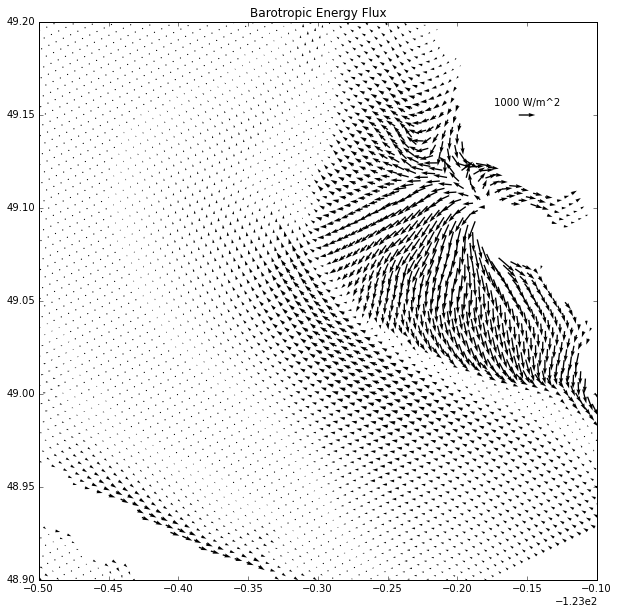

In [53]:
const='M2'
lons = sshstruc['lons'][0,0]
lats = sshstruc['lats'][0,0]

Fxbt,Fybt = barotropic_flux(sshstruc, btstruc, const)

fig,ax=plt.subplots(1,1,figsize=(10,10))
q=ax.quiver(lons,lats,Fxbt,Fybt)
ax.set_xlim([-123.5,-123.1])
ax.set_ylim([48.9,49.2])
ax.set_title('Barotropic Energy Flux')
ax.quiverkey(q,-123.15,49.15,1000,'1000 W/m^2',color='k', coordinates='data')

Depth-integrated will be more useful... More on this later.

# Baroclinic

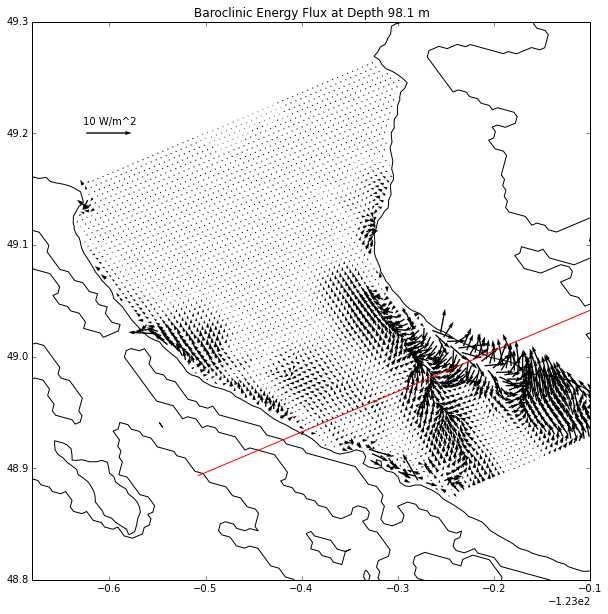

In [54]:
depths = pbc_t_struc['deptht'][0,0][:,0]

d=26
Fxbc,Fybc = baroclinic_flux(pbc_t_struc, bcstruc,const)
fig,ax=plt.subplots(1,1,figsize=(10,10))
q = ax.quiver(lons,lats,Fxbc[:,:,d],Fybc[:,:,d])
#ax.set_xlim([-123.5,-123.1])
#ax.set_ylim([48.9,49.2])
ax.set_title('Baroclinic Energy Flux at Depth {0:.3g} m'.format(depths[d]))
ax.quiverkey(q,-123.6,49.2,10,'10 W/m^2',color='k', coordinates='data')
viz_tools.plot_coastline(ax,grid,coords='map')
viz_tools.plot_coastline(ax,grid,coords='map',isobath=100)
ax.set_xlim([-123.68,-123.1])
ax.set_ylim([48.8,49.3])
jstart,istart = find_starting_index(NEMO_lons,NEMO_lats,lons[0,0],lats[0,0])
j=22
ax.plot([NEMO_lons[j+jstart,istart], NEMO_lons[j+jstart,-1]], 
        [NEMO_lats[j+jstart,istart], NEMO_lats[j+jstart,-1]],'r')

Rotate fluxes to NEMO coords. Plot vertical cross sections along above line.

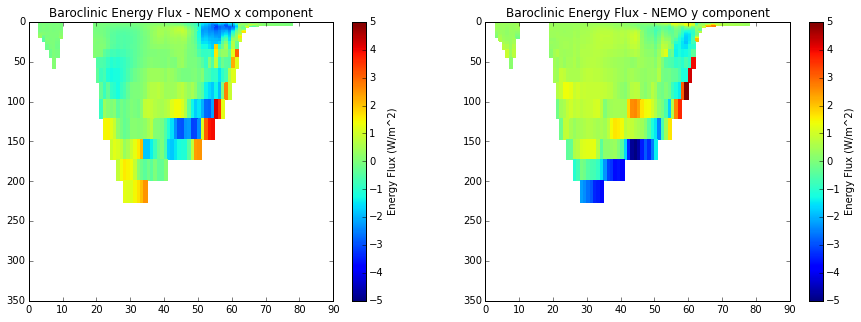

In [55]:
theta_rad = np.deg2rad(29)

Fx_NEMO=  Fxbc * np.cos(theta_rad) + Fybc * np.sin(theta_rad)
Fy_NEMO = -Fxbc * np.sin(theta_rad) + Fybc * np.cos(theta_rad)

fig,axs=plt.subplots(1,2,figsize=(15,5))
ax=axs[0]
mesh=ax.pcolormesh(np.arange(Fx_NEMO.shape[0]),depths,Fx_NEMO[:,j,:].T,vmin=-5,vmax=5)
cbar=plt.colorbar(mesh,ax=ax)
cbar.set_label('Energy Flux (W/m^2)')
ax.set_title('Baroclinic Energy Flux - NEMO x component')
ax=axs[1]
axs[1].pcolormesh(np.arange(Fy_NEMO.shape[0]),depths,Fy_NEMO[:,j,:].T)
cbar=plt.colorbar(mesh,ax=ax)
cbar.set_label('Energy Flux (W/m^2)')
ax.set_title('Baroclinic Energy Flux - NEMO y component')
for ax in axs:
    ax.set_ylim([350,0])

Why are the values so large on the right side of the slope? Why are they in the negative y direction at depth?

# Depth Integrated
Barotropic

In [56]:
column_depth = water_depth(tmask,e3t)
jend = jstart + Fxbt.shape[-1]
iend = istart + Fxbt.shape[0]

Fxbt_depint = Fxbt*column_depth[jstart:jend, istart:iend].T
Fybt_depint = Fybt*column_depth[jstart:jend, istart:iend].T


Baroclinic

In [57]:
Fxbc_depint = depth_integrate(Fxbc, np.transpose(tmask[:,jstart:jend,istart:iend], (2,1,0)),
                              np.transpose(e3t[:,jstart:jend,istart:iend],(2,1,0)))
Fybc_depint = depth_integrate(Fybc, np.transpose(tmask[:,jstart:jend,istart:iend], (2,1,0)),
                              np.transpose(e3t[:,jstart:jend,istart:iend],(2,1,0)))

/home/nsoontie/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:1: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  if __name__ == '__main__':
/home/nsoontie/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:2: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  from ipykernel import kernelapp as app
/home/nsoontie/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:3: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  app.launch_new_instance()
/home/nsoontie/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:4: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


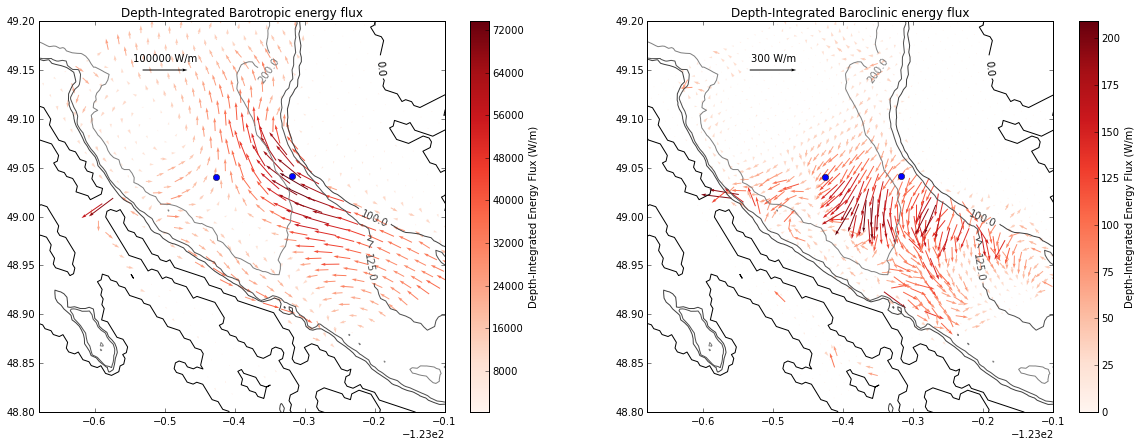

In [58]:
fig,axs=plt.subplots(1,2,figsize=(20,7))
st=3
#barotropic
ax=axs[0]
bt_mag = np.sqrt(Fxbt_depint**2 + Fybt_depint**2)
q=ax.quiver(lons[::st,::st],lats[::st,::st],
            Fxbt_depint[::st,::st],Fybt_depint[::st,::st],bt_mag[::st,::st],
            cmap='Reds')
cbar=plt.colorbar(q,ax=ax)
cbar.set_label('Depth-Integrated Energy Flux (W/m)')
ax.set_title('Depth-Integrated Barotropic energy flux')
ax.quiverkey(q,-123.5,49.15,100000,'100000 W/m',color='k', coordinates='data')
#baroclinic
st=2
ax=axs[1]
bc_mag = np.sqrt(Fxbc_depint**2 + Fybc_depint**2)
q=ax.quiver(lons[::st,::st],lats[::st,::st],
            Fxbc_depint[::st,::st],Fybc_depint[::st,::st],bc_mag[::st,::st],
            cmap='Reds')
cbar=plt.colorbar(q,ax=ax)
cbar.set_label('Depth-Integrated Energy Flux (W/m)')
ax.set_title('Depth-Integrated Baroclinic energy flux')
ax.quiverkey(q,-123.5,49.15,300,'300 W/m',color='k', coordinates='data')

manuel_locations=[(-123.2,49.15),(-123.2,49),(-123.2,48.95),(-123.35,49.15)]
names=['Central','East']
for ax in axs:
    C=ax.contour(NEMO_lons,NEMO_lats,bathy.data,[0,100,125,200], cmap='gray',vmin=0,vmax=400)
    ax.set_xlim([-123.68,-123.1])
    ax.set_ylim([48.8,49.2])
    plt.clabel(C,fmt='%1.1f',ax=ax,manual=manuel_locations)
    for name in names:
        ax.plot(SITES[name]['lon'],SITES[name]['lat'],'bo')

How can I check if my calculations make sense?
* Foreman 1995 did similar barotropic calculations through Haro Strait. Perhaps I can repeat mine there....
* Can I do this without the harmonic analysis?